# Common Group Themes of Perfume

## Importing Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches
import joblib
import os

In [12]:
df = pd.read_csv('../data/raw/final_perfume_data.csv', encoding='ISO-8859-1')
df.head()


,Name,Brand,Description,Notes,Image URL
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, ...","Vanilla bean, musks",https://static.luckyscent.com/images/products/...
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending f...,"Lavender, Yuzu, Lemongrass, Magnolia, Geraniu...",https://static.luckyscent.com/images/products/...
2,Kagiroi Parfum,Di Ser,An aromatic ode to the ancient beauty of Japa...,"Green yuzu, green shikuwasa, sansho seed, cor...",https://static.luckyscent.com/images/products/...
3,Velvet Fantasy Eau de Parfum,Montale,Velvet Fantasy is a solar fragrance where cit...,"tangerine, pink pepper, black coffee, leat...",https://static.luckyscent.com/images/products/...
4,A Blvd. Called Sunset Eau de Parfum,A Lab on Fire,There's no way A Lab On Fire could relocate t...,"Bergamot, almond, violet, jasmine, leather, s...",https://static.luckyscent.com/images/products/...


In [13]:
# Configuration
DATA_PATH = "../data/raw/final_perfume_data.csv"
CLEANED_NOTES_PATH = "../data/cleaned_perfume_notes.txt"
MODEL_DIR = "../models/"
os.makedirs(MODEL_DIR, exist_ok=True)

## Data Preprocessing

In [14]:
def load_and_preprocess_data():
    """Load and preprocess perfume data."""
    # Load cleaned notes vocabulary
    with open(CLEANED_NOTES_PATH, "r", encoding="utf-8") as f:
        valid_notes = set(f.read().splitlines())

    # Load dataset
    df = pd.read_csv(DATA_PATH, encoding="ISO-8859-1")
    
    # Preprocessing
    df = df[['Name', 'Brand', 'Notes']].copy()
    df.dropna(subset=['Notes'], inplace=True)
    df['Name'] = df['Name'].str.lower().str.strip()
    
    # Remove duplicates
    if df.duplicated(subset=['Name']).any():
        df = df.drop_duplicates(subset=['Name'])
    
    # Filter valid notes
    df['Notes'] = df['Notes'].apply(
        lambda x: ', '.join([note.strip() for note in x.split(',') if note.strip() in valid_notes])
    )
    df = df[df['Notes'].str.strip() != '']
    df.reset_index(drop=True, inplace=True)
    df.head()

    return df

##  Model Training

In [15]:
def train_clustering_model(df, force_retrain=False):
    """Train or load TF-IDF vectorizer and clustering model."""
    model_path = os.path.join(MODEL_DIR, "clustering.pkl")
    
    if not force_retrain and os.path.exists(model_path):
        return joblib.load(model_path)
    
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X_notes = vectorizer.fit_transform(df['Notes'])
    
    # Find optimal cluster count
    silhouette_scores = []
    k_range = range(2, 15)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_notes)
        score = silhouette_score(X_notes, labels)
        silhouette_scores.append(score)
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    
    # Train final model
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    final_kmeans.fit(X_notes)
    
    # Save models
    model_data = {
        'vectorizer': vectorizer,
        'kmeans': final_kmeans,
        'X_notes': X_notes,
        'optimal_k': optimal_k
    }
    joblib.dump(model_data, model_path)
    
    return model_data

In [16]:
def visualize_clusters(X_reduced, labels):
    """Visualize clusters in 2D space."""
    df_plot = pd.DataFrame(X_reduced, columns=['Dim1', 'Dim2'])
    df_plot['Cluster'] = labels
    
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df_plot, x='Dim1', y='Dim2', hue='Cluster', 
                    palette='viridis', s=60, alpha=0.8)
    plt.title("Perfume Clusters Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [17]:
def get_cluster_terms(vectorizer, kmeans, n_terms=10):
    """Display top terms for each cluster."""
    terms = vectorizer.get_feature_names_out()
    for cluster_id in range(kmeans.n_clusters):
        centroid = kmeans.cluster_centers_[cluster_id]
        top_terms = terms[np.argsort(centroid)[-n_terms:][::-1]]
        print(f"Cluster {cluster_id} Top Terms: {', '.join(top_terms)}")

In [18]:
def recommend_perfumes(df, model_data, perfume_name, num_recs=5):
    """
    Get perfume recommendations based on scent similarity.
    
    Args:
        df: Preprocessed DataFrame
        model_data: Trained model artifacts
        perfume_name: Input perfume name
        num_recs: Number of recommendations to return
    
    Returns:
        DataFrame with recommendations or error message
    """
    # Normalize input
    perfume_name = perfume_name.lower().strip()
    
    # Fuzzy name matching
    if perfume_name not in df['Name'].values:
        matches = get_close_matches(perfume_name, df['Name'], n=1)
        if not matches:
            return f"No perfume found matching '{perfume_name}'"
        perfume_name = matches[0]
        print(f"Did you mean: '{perfume_name}'?")
    
    # Get perfume data
    perfume_data = df[df['Name'] == perfume_name]
    if perfume_data.empty:
        return f"Perfume '{perfume_name}' not found in database"
    
    idx = perfume_data.index[0]
    cluster = model_data['kmeans'].labels_[idx]
    
    # Get cluster members
    cluster_mask = (model_data['kmeans'].labels_ == cluster)
    cluster_df = df[cluster_mask].copy()
    cluster_df = cluster_df[cluster_df['Name'] != perfume_name]
    
    if cluster_df.empty:
        return f"No similar perfumes found in cluster {cluster}"
    
    # Calculate similarities
    similarities = cosine_similarity(
        model_data['X_notes'][idx],
        model_data['X_notes'][cluster_df.index]
    ).flatten()
    
    # Prepare results
    results = cluster_df.assign(Similarity=similarities)
    results = results.sort_values('Similarity', ascending=False)
    
    # Return top N with similarity scores
    return results[['Name', 'Brand', 'Notes', 'Similarity']].head(num_recs)

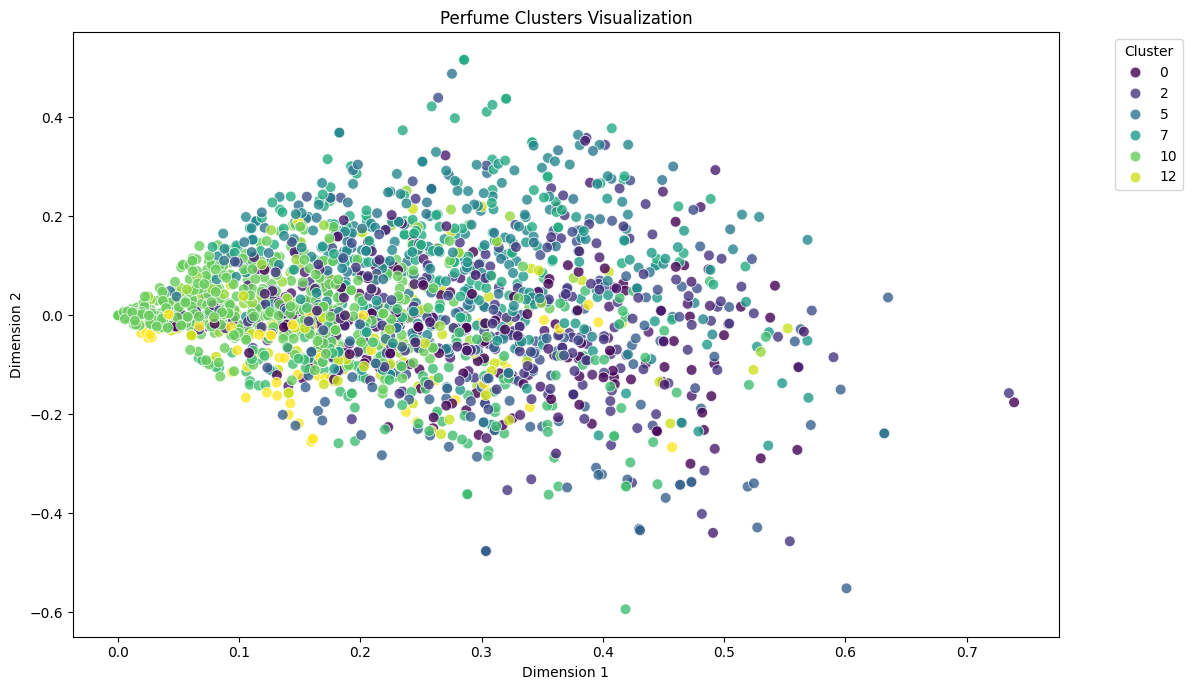

Cluster 0 Top Terms: saffron, oud, patchouli, amber, leather, sandalwood, rose, cedar, musk, vanilla
Cluster 1 Top Terms: incense, patchouli, amber, vetiver, sandalwood, musk, bergamot, leather, vanilla, oud
Cluster 2 Top Terms: rose, musk, patchouli, vanilla, bergamot, jasmine, amber, lemon, sandalwood, violet
Cluster 3 Top Terms: coriander, patchouli, musk, vetiver, amber, vanilla, bergamot, cardamom, jasmine, cedar
Cluster 4 Top Terms: amber, musk, sandalwood, jasmine, patchouli, iris, vanilla, bergamot, citrus, lemon
Cluster 5 Top Terms: neroli, bergamot, sandalwood, mandarin, musk, jasmine, lemon, rose, vetiver, petitgrain
Cluster 6 Top Terms: vetiver, lavender, patchouli, cedarwood, nutmeg, lemon, cardamom, sandalwood, bergamot, grapefruit
Cluster 7 Top Terms: cinnamon, sandalwood, cedar, patchouli, vanilla, cardamom, bergamot, musk, amber, clove
Cluster 8 Top Terms: bergamot, cedar, musk, patchouli, jasmine, lemon, vanilla, oakmoss, iris, vetiver
Cluster 9 Top Terms: vanilla, sa

In [20]:
def main():
    # Load and preprocess data
    df = load_and_preprocess_data()

    # Train or load models
    model_data = train_clustering_model(df)
    
    # Add cluster labels to DataFrame
    df['Cluster'] = model_data['kmeans'].labels_
    
    # Visualize clusters
    svd = TruncatedSVD(n_components=2)
    X_svd = svd.fit_transform(model_data['X_notes'])
    visualize_clusters(X_svd, df['Cluster'])
    
    # Show cluster terms
    get_cluster_terms(model_data['vectorizer'], model_data['kmeans'])
    
    # Example recommendation
    test_perfume = "oud dream eau de parfum"
    recommendations = recommend_perfumes(df, model_data, test_perfume)
    
    print(f"\nRecommendations for '{test_perfume}':")
    print(recommendations.to_string(index=False) if isinstance(recommendations, pd.DataFrame) else recommendations)

if __name__ == "__main__":
    main()

1. Oriental/Oud Group
Clusters: 0, 1, 12

Key Notes: Oud, saffron, amber, incense, leather, tobacco

Characteristics: Rich, smoky, resinous scents with Middle Eastern influences

2. Floral Group
Subgroups:

Soft Floral (Cluster 2): Rose, jasmine, violet, musk

White Floral (Cluster 10): Tuberose, jasmine, sandalwood

Powdery Floral (Cluster 4): Iris, amber, citrus

Characteristics: Feminine-leaning bouquets with varying degrees of sweetness/powderiness

3. Woody/Spicy Group
Clusters: 3, 6, 7, 11

Key Notes: Vetiver, cedar, patchouli, cardamom, nutmeg, cypress

Characteristics: Earthy, aromatic scents with herbal/spicy complexity

4. Citrus/Fresh Group
Cluster: 5

Key Notes: Bergamot, neroli, mandarin, petitgrain

Characteristics: Bright, zesty fragrances with Mediterranean vibes

5. Sweet/Gourmand Group
Clusters: 9, 13

Key Notes: Vanilla, labdanum, benzoin, coconut, almond

Characteristics: Edible, dessert-like sweetness with creamy textures

6. Chypre/Classic Group
Cluster: 8

Key Notes: Oakmoss, bergamot, cedar, iris

Characteristics: Timeless sophistication with mossy-woody undertones

7. Leather/Tobacco Group
Cluster: 12 (also overlaps with Oriental)

Key Notes: Leather, rum, tobacco, oakmoss

Characteristics: Masculine, smoky, and boozy accords

Key Observations:
Patchouli Dominance: Appears in 11/14 clusters, showing its versatility

Gender Fluidity: Most clusters contain both masculine (vetiver, leather) and feminine (floral) elements

Modern Trends:

Cluster 13 (gourmand) reflects the popular vanilla/coconut trend

Cluster 0 (oud) shows the Western adoption of Middle Eastern notes

Seasonal Associations:

Citrus (Cluster 5) = Summer

Oriental/Leather (Clusters 0,12) = Winter

Floral (Clusters 2,10) = Spring

Recommendation Strategy:
Cluster 0 (Oud/Saffron) ↔ Cluster 12 (Tobacco/Leather): For lovers of intense, smoky scents

Cluster 5 (Citrus) ↔ Cluster 6 (Aromatic Woody): Fresh-to-earthy transitions

Cluster 9 (Sweet Oriental) ↔ Cluster 13 (Gourmand): Sweetness spectrum navigation

In [22]:
df = load_and_preprocess_data()
df.head()


,Name,Brand,Notes
0,tihota eau de parfum,Indult,musks
1,sola parfum,Di Ser,"Lavender, Yuzu, Lemongrass, Magnolia, Geranium..."
2,kagiroi parfum,Di Ser,"coriander, shiso, rosewood, vetiver, hinoki, c..."
3,velvet fantasy eau de parfum,Montale,"tangerine, leather, violet, jasmine, vanilla, ..."
4,a blvd. called sunset eau de parfum,A Lab on Fire,"Bergamot, almond, violet, jasmine, leather, sa..."
